# #Multisight

The part that takes the most time is the final one in which I propagate the field into a volume inside the crystal medium.
Let me package this function into an individual script that I might be able to run on CCV.

In [3]:
%load_ext autoreload
%autoreload 2
import sys
import os
codebase_dir = '/Users/juan/ZiaLab/Codebase'
sys.path.append(codebase_dir)
import wavesight as ws
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import h5py
from scipy.optimize import fsolve, root_scalar
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
%config InlineBackend.figure_format='retina'
import warnings
print("Warning disabling RuntimeWarning often due to evalution of square roots with negative arguments.\nProbably produced by scalar_root.")
warnings.filterwarnings("ignore", category=RuntimeWarning)
import cmasher as cmr
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Warning disabling RuntimeWarning often due to evalution of square roots with negative arguments.
Probably produced by scalar_root.


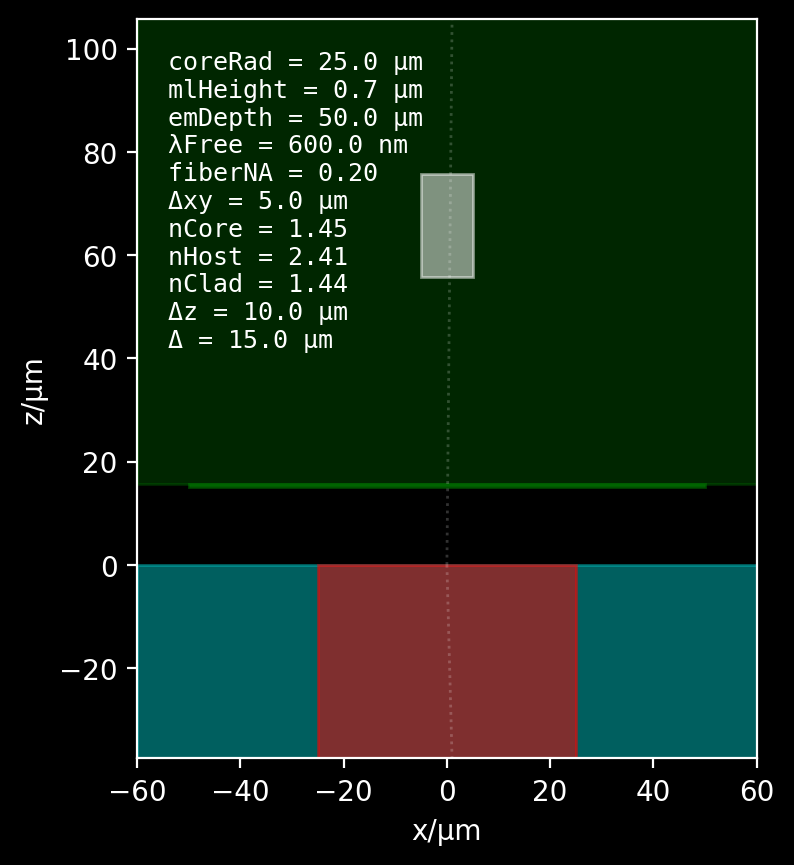

In [4]:
dev_design = {'coreRadius':25., 
              'mlRadius':50., 
              'Δ':15., 
              'mlPitch':0.3,
              'NA': 0.20,
              'emDepth':50., 
              'emΔxy':5., 
              'emΔz':10., 
              'mlHeight':0.7, 
              'nCore':1.45, 
              'nHost':2.41, 
              'nCore':1.45, 
              'λFree':0.6}
fig, ax = ws.device_layout(dev_design)
fig

In [5]:
# FG050LGA
fiber_spec = {'NA': 0.22,
              'nCore': 1.45,
              'coreRadius':25.,
              'grid_divider': 2,
              'nFree': 1.,
              'λFree': 0.600}
fiber_sol = ws.multisolver(fiber_spec, solve_modes = 'transverse', drawPlots=False, verbose=True)
fiber_sol = ws.calculate_numerical_basis(fiber_sol)

Estimating nCladding from nCore and NA ...
Approx number of complex HE modes:  800
Approx number of TE modes:  28
Approx number of TM modes:  28
Approx number of total modes:  1658
Approx Max n for HE modes:  40
Calculating TE(0,n) propagation constants ...
Calculating TM(0,n) propagation constants ...

HE modes = 0
TE modes = 36
TM modes = 36
TOTAL modes = 72
FROM_Vnum = 1658


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
plot_slices = True
# job_size = len(fiber_sol['eigenbasis_nums'])
job_size = 36
for eigen_index in tqdm(range(job_size)):
    h5fname = './slices/slice-%d.h5' % eigen_index
    if os.path.exists(h5fname):
        print("Already done idx=%d" % eigen_index)
        continue
    # grab the data for the mode of interest
    (modtype, m, kzidx, γ, β, Ae, Ah, Be, Bh) = fiber_sol['eigenbasis_nums'][eigen_index]
    kz = fiber_sol['TEkz'][0][0]
    fiber_sol['coord_layout'] = ws.coordinate_layout(fiber_sol)
    a, b, Δs, xrange, yrange, ρrange, φrange, Xg, Yg, ρg, φg, nxy, crossMask, numSamples = fiber_sol['coord_layout']

    totalModes = fiber_sol['totalModes']
    λfree = fiber_sol['λFree']
    eigenbasis = fiber_sol['eigenbasis']
    nCore = fiber_sol['nCore']
    nCladding = fiber_sol['nCladding']

    nFree = 1.0
    Einc = eigenbasis[eigen_index, 0, :, :, :]
    Hinc = np.conjugate(eigenbasis[eigen_index, 1, :, :, :])
    kref, Eref, Href = ws.poyntingrefractor(Einc, Hinc, nFree, nxy, verbose=True)

    print("Converting cylindrical anchored to cartesian into cartesian anchored to cartesian...")
    Erefcc = ws.from_cyl_cart_to_cart_cart(Eref)
    Hrefcc = ws.from_cyl_cart_to_cart_cart(Href)
    ζCoords = np.linspace(-b,b,numSamples)
    ηCoords = np.linspace(-b,b,numSamples)

    print("Propagating the field from across the gap...")
    nref = 1.
    zProp = dev_design['Δ']
    (xCoords, yCoords, E3) = ws.vector_field_FFT_RS_prop_array(zProp, Erefcc, ζCoords, ηCoords, λfree, nref)
    (xCoords, yCoords, H3) = ws.vector_field_FFT_RS_prop_array(zProp, Hrefcc, ζCoords, ηCoords, λfree, nref)

    print("Calculating the ideal Fresnel phase profile...")
    λFree = dev_design['λFree']
    nHost = dev_design['nHost']
    λHost = λFree / nHost
    Rmax = 20 # arbitrary
    emDepth = dev_design['emDepth']
    def fresnel_profile(f):
        phase_fun = lambda x,y: (np.sqrt(x**2+y**2 + f**2)-f)
        return phase_fun
    fp = fresnel_profile(emDepth)
    phase_map = -2*np.pi/λHost * fp(Xg,Yg)
    complex_phase_map = np.exp(1j * phase_map)
    complex_phase_map[Xg**2 + Yg**2 > Rmax**2] = 0

    print("Letting field through meta-optic...")
    E4 = E3 * complex_phase_map
    H4 = H3 * complex_phase_map

    print("Determining range of zProp values to use...")
    dl = xrange[1]-xrange[0]
    emΔz = dev_design['emΔz']
    emDepth = dev_design['emDepth']
    zrange = np.linspace(emDepth-emΔz, emDepth+emΔz, int(2*emΔz/dl))

    print("Filling an empty array for the final fields ...")
    E5 = np.zeros((*E4.shape, len(zrange)))
    H5 = np.zeros((*H4.shape, len(zrange)))

    print("Propagating the field inside of the crystal host...")
    nref = dev_design['nHost']
    λFree = dev_design['λFree']
    for field_index in [0,1]:
        if field_index == 0:
            sourceField = E4
        else:
            sourceField = H4
        for z_index, zProp in enumerate(tqdm(zrange)):
            (xCoords, yCoords, fields) = ws.vector_field_FFT_RS_prop_array(zProp, sourceField, ζCoords, ηCoords, λFree, nref)
            if field_index == 0:
                E5[:, :, :, z_index] = fields
            else:
                H5[:, :, :, z_index] = fields
    if plot_slices:
        print("Grabbing the electric field energy density along the sagittal plane...")
        pField = H5
        fig_fname = './slices/slice-%d.png' % eigen_index
        midIndex = pField.shape[1] // 2
        slice = pField[:, midIndex, :, :]
        slice = np.sum(np.abs(slice)**2, axis=0)
        print("Plotting the slice")
        vmax = np.max(slice)
        plt.figure(figsize=(10,2))
        plt.imshow(slice.T,
            extent=[-b,b,zrange[0],zrange[-1]],
            cmap=cmr.ember,
            norm=LogNorm(vmin=vmax*1e-3, vmax=vmax),
            )
        plt.xlabel('x/um')
        plt.ylabel('z/um')
        plt.title('|E|^2')
        plt.colorbar()
        plt.savefig(fig_fname, dpi=300)
        plt.close()
    with h5py.File(h5fname, 'w') as f:
        f.create_dataset('E5', data=E5, compression='gzip')
        f.create_dataset('H5', data=H5, compression='gzip')

In [37]:
jobSize = 36
for eigen_index in tqdm(range(jobSize)):
    h5_file = h5py.File('./slices/slice-%d.h5' % eigen_index,'r')
    list(h5_file.keys())
    E5 = np.array(h5_file['/E5'])
    h5_file.close()
    print("Grabbing the electric field energy density along the sagittal plane...")
    pField = E5
    fig_fname = './slices/slice-%d.png' % eigen_index
    midIndex = pField.shape[1] // 2
    slice = pField[:, midIndex, :, :]
    slice = np.sum(np.abs(slice)**2, axis=0)
    print("Plotting the slice")
    vmax = np.max(slice)
    plt.figure(figsize=(10,10))
    plt.imshow(slice.T,
        extent=[-b,b,zrange[0],zrange[-1]],
        cmap=cmr.ember,
        norm=LogNorm(vmin=vmax*1e-3, vmax=vmax),
        )
    plt.xlim(-10,10)
    plt.xlabel('x/um')
    plt.ylabel('z/um')
    plt.title('|E|^2')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(fig_fname, dpi=300)
    plt.close()

  0%|          | 0/36 [00:00<?, ?it/s]

Grabbing the electric field energy density along the sagittal plane...
Plotting the slice
Grabbing the electric field energy density along the sagittal plane...
Plotting the slice
Grabbing the electric field energy density along the sagittal plane...
Plotting the slice
Grabbing the electric field energy density along the sagittal plane...
Plotting the slice
Grabbing the electric field energy density along the sagittal plane...
Plotting the slice
Grabbing the electric field energy density along the sagittal plane...
Plotting the slice
Grabbing the electric field energy density along the sagittal plane...
Plotting the slice
Grabbing the electric field energy density along the sagittal plane...
Plotting the slice
Grabbing the electric field energy density along the sagittal plane...
Plotting the slice
Grabbing the electric field energy density along the sagittal plane...
Plotting the slice
Grabbing the electric field energy density along the sagittal plane...
Plotting the slice
Grabbing t

In [50]:
pField.shape

(3, 362, 362, 96)

In [51]:
sag_slices = []
med_slices = []
jobSize = 36
for eigen_index in tqdm(range(jobSize)):
    h5_file = h5py.File('./slices/slice-%d.h5' % eigen_index,'r')
    list(h5_file.keys())
    E5 = np.array(h5_file['/E5'])
    h5_file.close()
    # print("Grabbing the electric field energy density along the sagittal plane...")
    pField = E5
    fig_fname = './slices/slice-%d.png' % eigen_index
    midIndex = pField.shape[1] // 2
    slice = pField[:, midIndex, :, :]
    slice = np.sum(np.abs(slice)**2, axis=0)
    medIndex = pField.shape[-1] // 2
    medial_field =  pField[:, :, :, medIndex]
    medial_field = np.sum(np.abs(medial_field)**2, axis=0)
    med_slices.append(medial_field)
    sag_slices.append(slice)

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

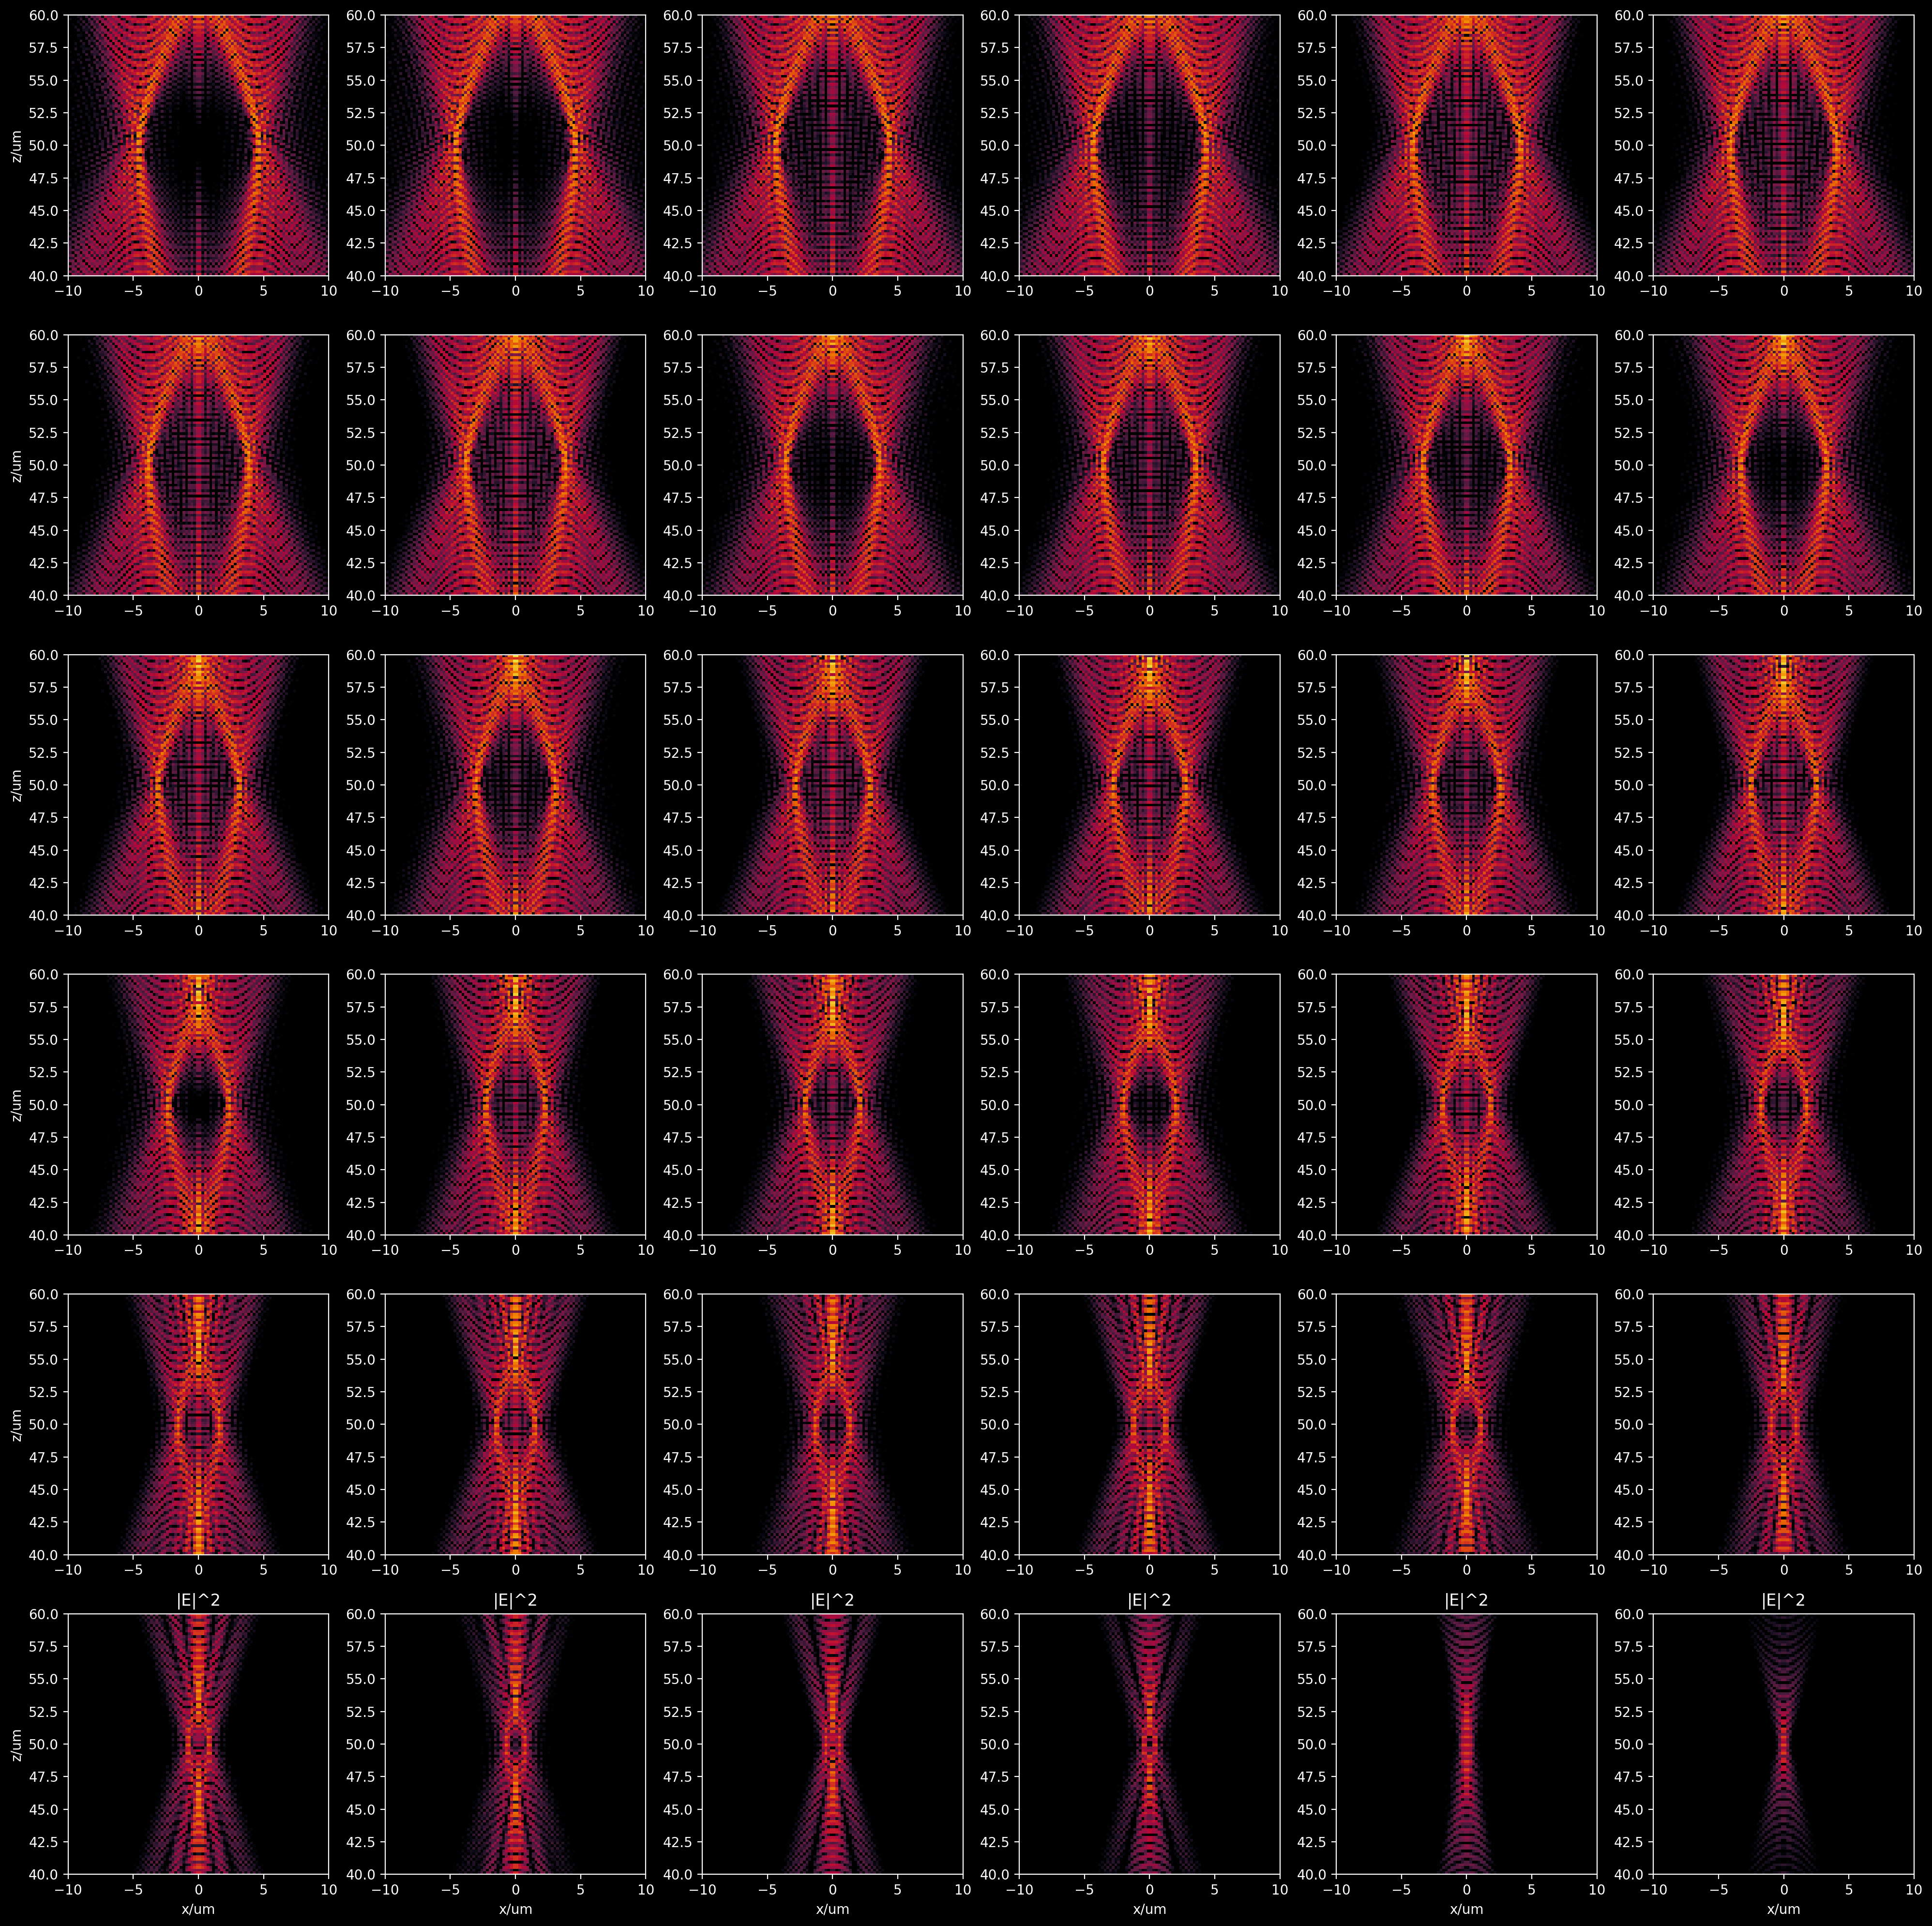

In [90]:
vmax = np.max(np.array(sag_slices))
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(20,20))
for eigen_index in tqdm(range(jobSize)):
    slice = sag_slices[eigen_index]
    # print("Plotting the slice")
    # vmax = np.max(slice)
    nrow, ncol = eigen_index//6, eigen_index%6
    axis = axes[nrow, ncol]
    ishow = axis.imshow(slice.T,
        extent=[-b,b,zrange[0],zrange[-1]],
        cmap=cmr.ember,
        norm=LogNorm(vmin=vmax*1e-4, vmax=vmax),
        )
    axis.set_xlim(-10,10)
    if ncol == 0:
        axis.set_ylabel('z/um')
    if nrow == 5:
        axis.set_xlabel('x/um')
        axis.set_title('|E|^2')
plt.tight_layout()
plt.savefig('./slices/all_sag_slices.png', dpi=300)
plt.savefig('./slices/all_sag_slices.pdf')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
plt.colorbar(ishow, ax=ax)
ax.remove()
plt.savefig('./slices/all_sag_slices-colorbar.png', dpi=300)
plt.savefig('./slices/all_sag_slices-colorbar.pdf')
plt.close()

  0%|          | 0/36 [00:00<?, ?it/s]

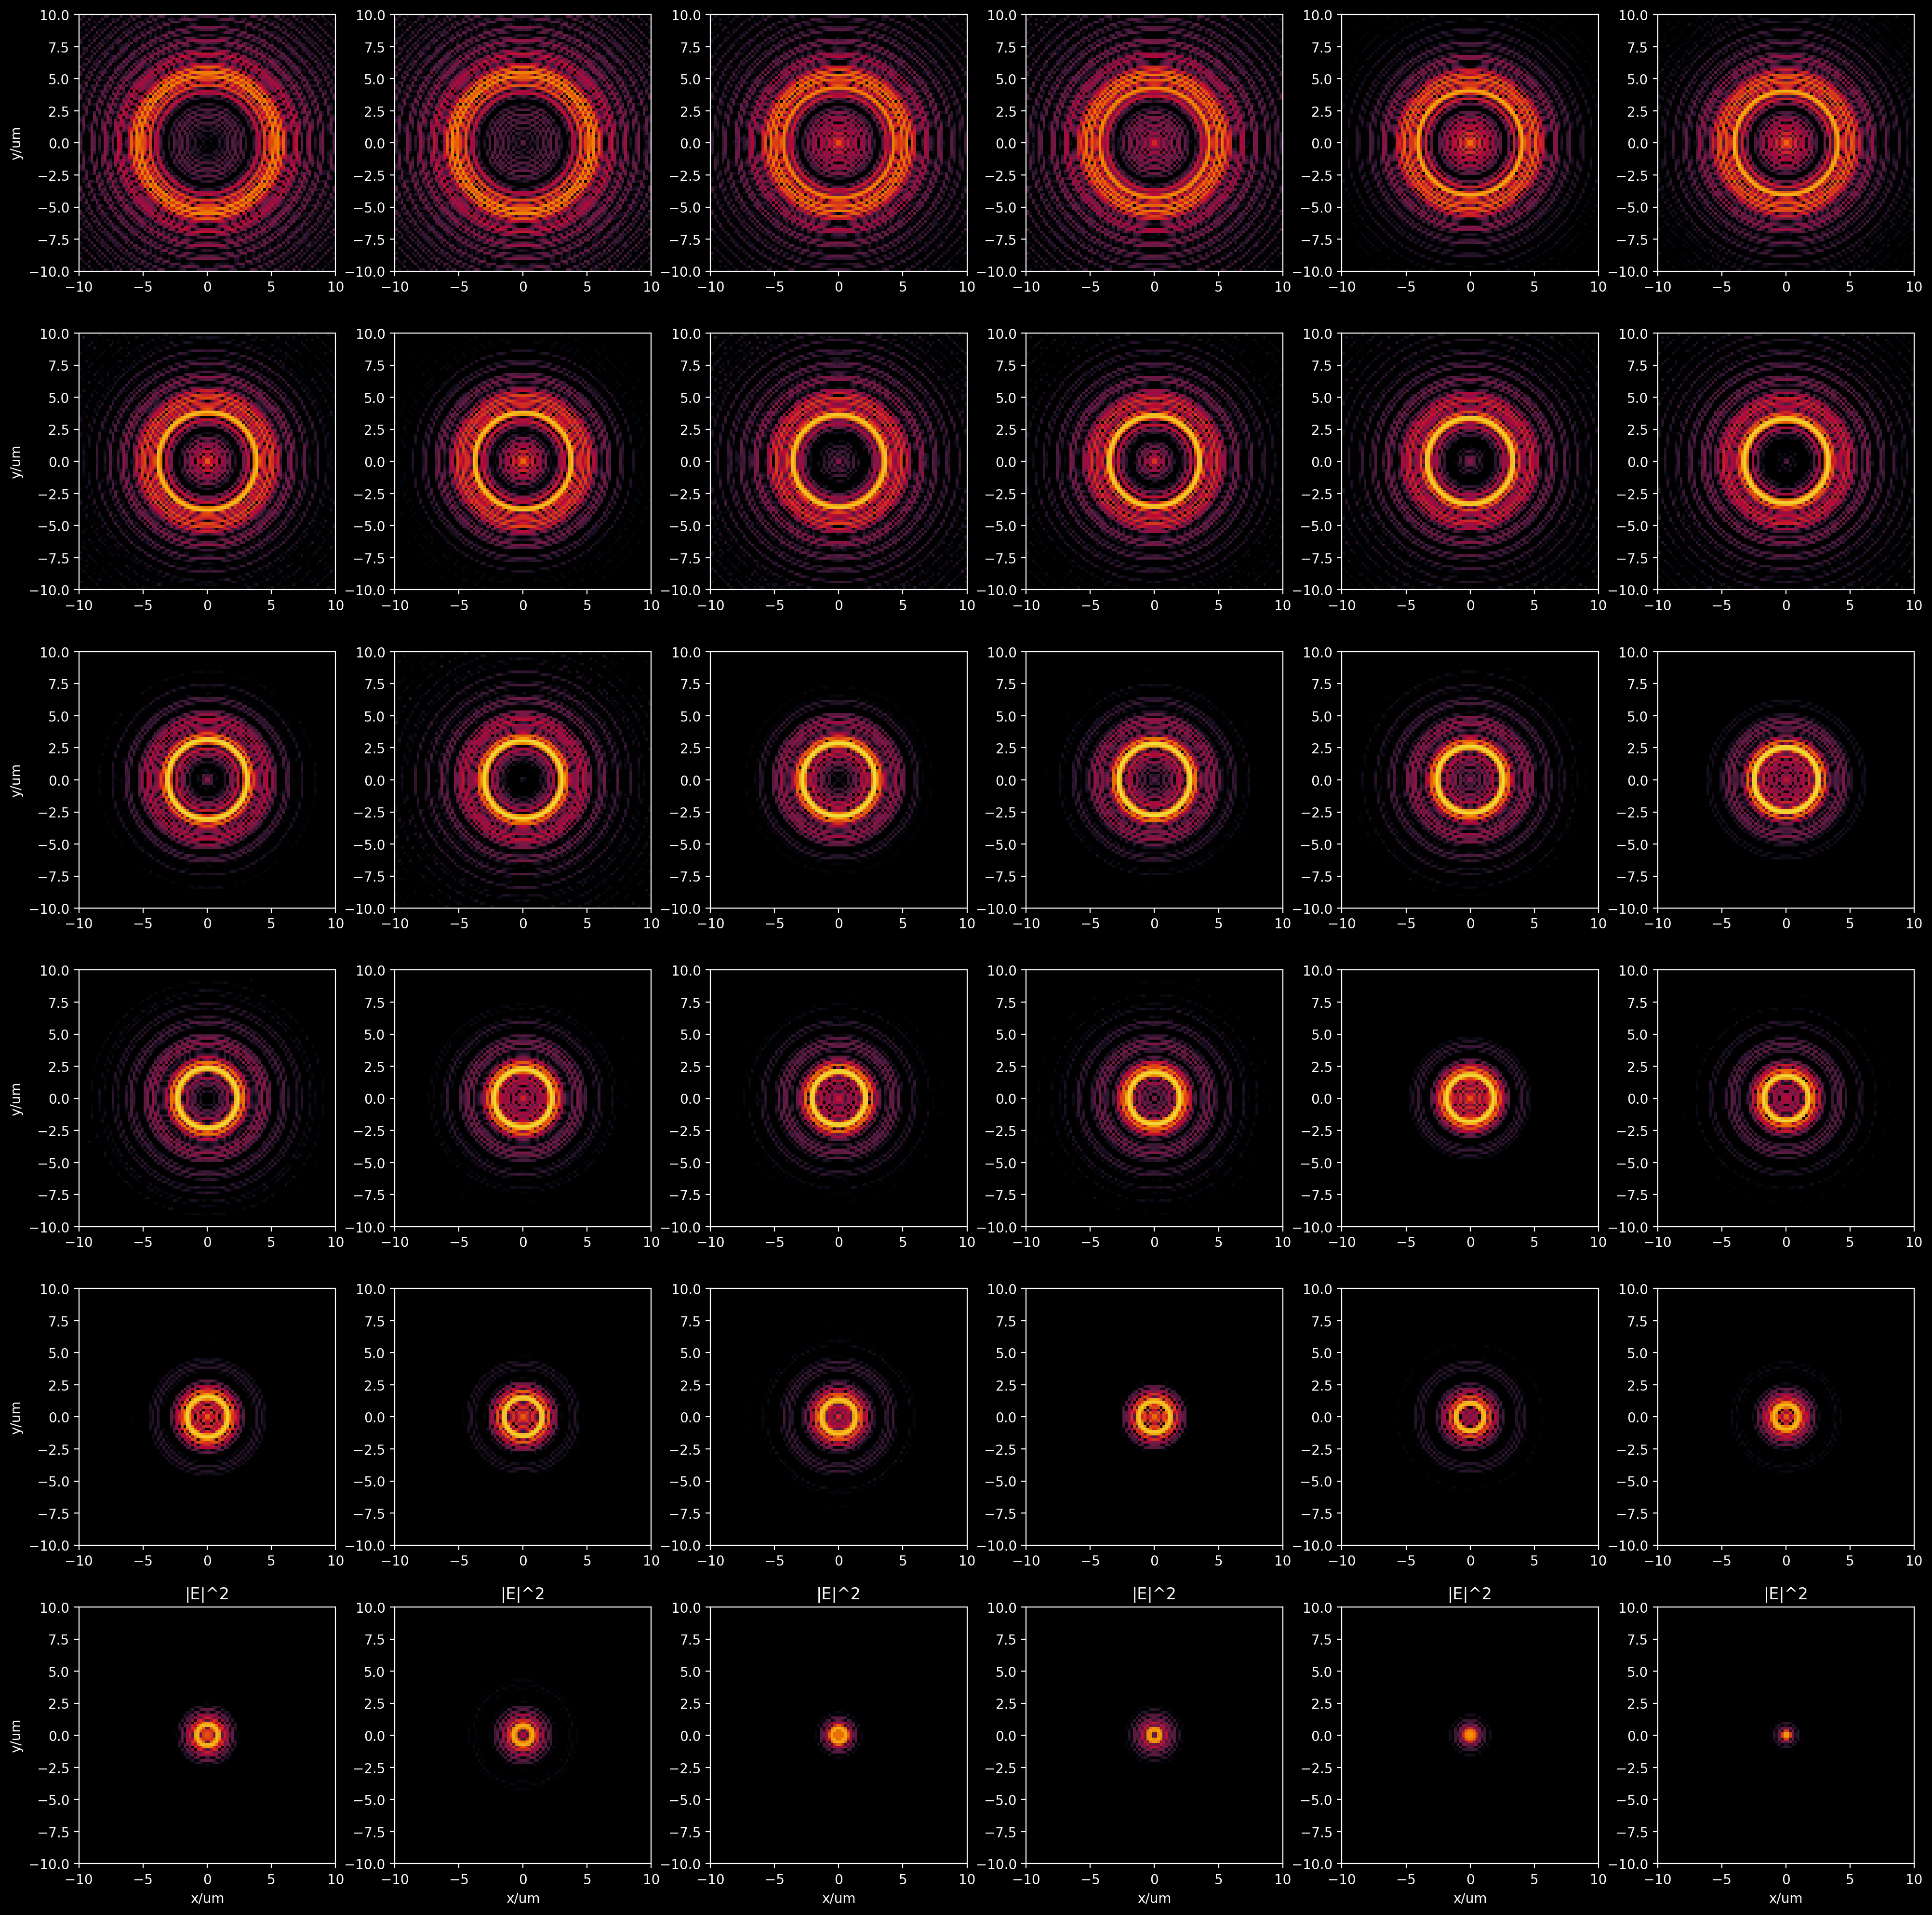

In [89]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(20,20))
vmax = np.max(np.array(med_slices))
for eigen_index in tqdm(range(jobSize)):
    slice = med_slices[eigen_index]
    # print("Plotting the slice")
    # vmax = np.max(slice)
    nrow, ncol = eigen_index//6, eigen_index%6
    axis = axes[nrow, ncol]
    ishow = axis.imshow(slice.T,
        extent=[-b,b,-b,b],
        cmap=cmr.ember,
        norm=LogNorm(vmin=vmax*1e-4, vmax=vmax),
        )
    axis.set_xlim(-10,10)
    axis.set_ylim(-10,10)
    if ncol == 0:
        axis.set_ylabel('y/um')
    if nrow == 5:
        axis.set_xlabel('x/um')
        axis.set_title('|E|^2')
plt.tight_layout()
plt.savefig('./slices/all_median_slices.png', dpi=300)
plt.savefig('./slices/all_median_slices.pdf')
plt.show()
fig, ax = plt.subplots(figsize=(10,10))
plt.colorbar(ishow, ax=ax)
ax.remove()
plt.savefig('./slices/all_median_slices-colorbar.png', dpi=300)
plt.savefig('./slices/all_median_slices-colorbar.pdf')
plt.close()

In [59]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [60]:
annotations = []

for modtype in ['TE','TM','HE']:
    solkey = modtype + 'kz'
    for m, kzs in fiber_sol[solkey].items():
        for kzidx, kz in enumerate(kzs):
            γ = np.sqrt(nCore**2*4*np.pi**2/λfree**2 - kz**2)
            β = np.sqrt(kz**2 - nCladding**2*4*np.pi**2/λfree**2)
            annotationTR = '%s(%d,%d)' % (modtype, m, kzidx)
            annotationBR = 'kz=%.3f µm⁻¹' % (kz)
            annotations.append((annotationTR, annotationBR))

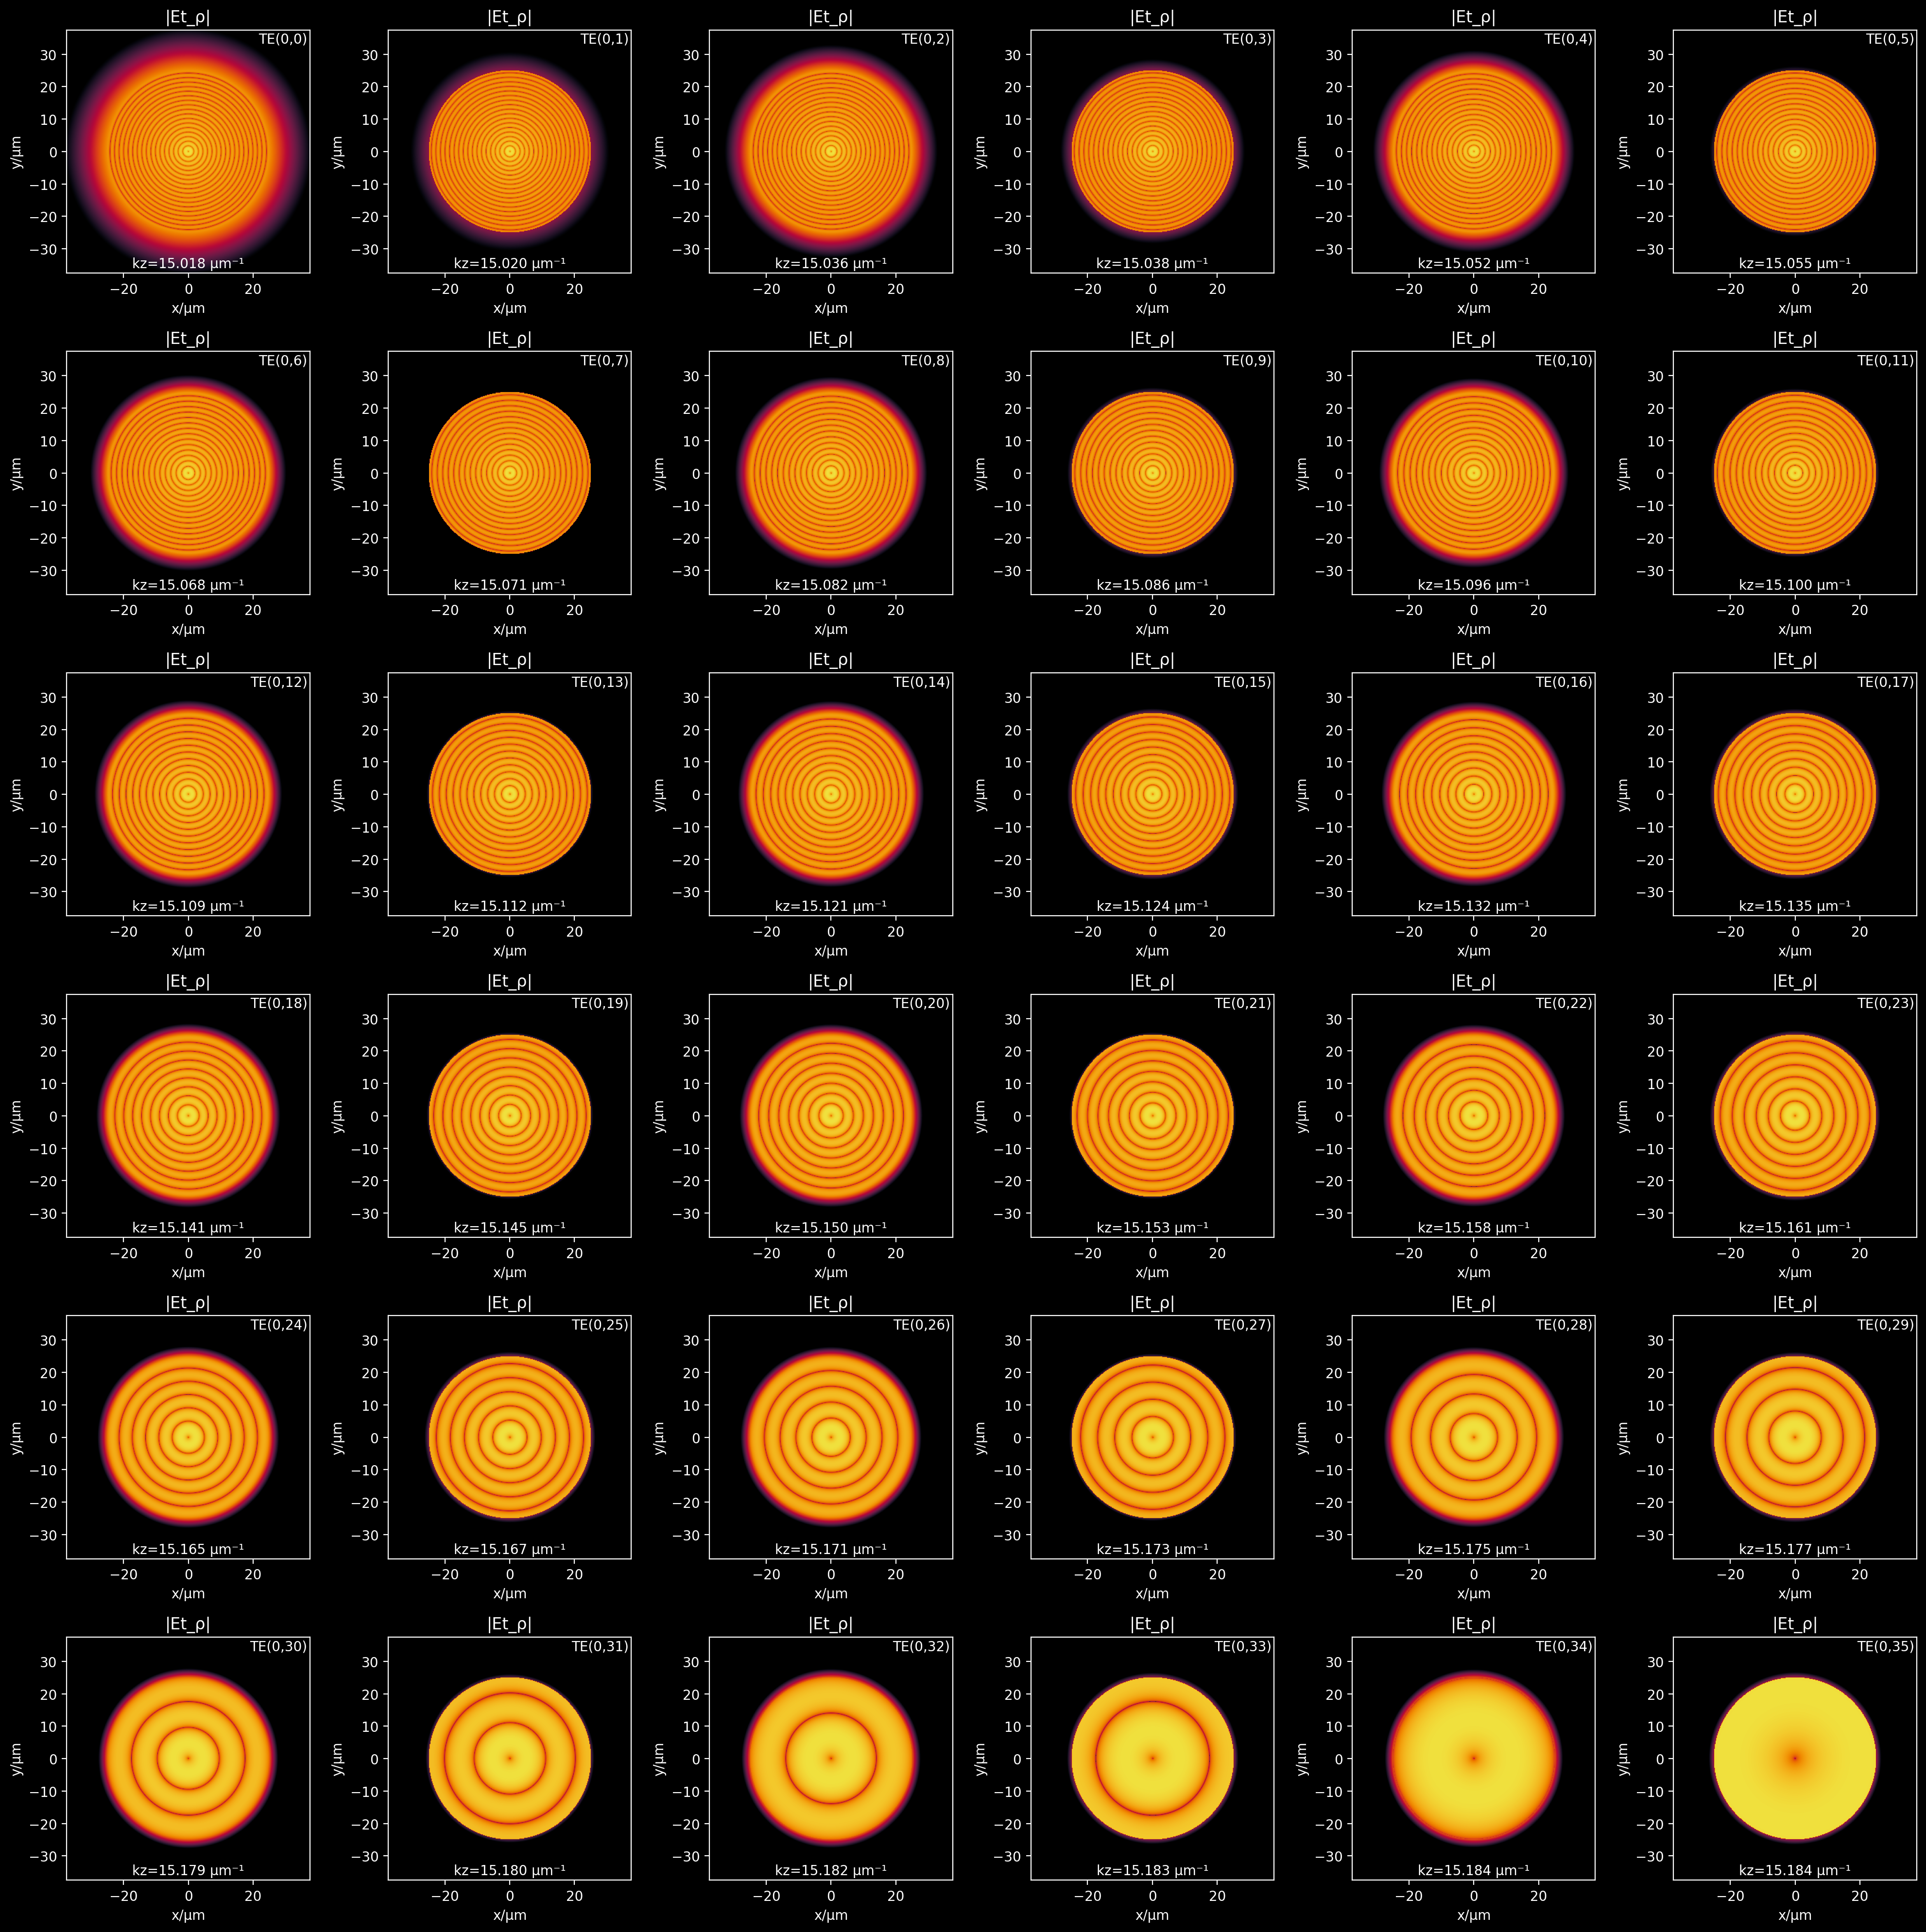

In [88]:
# plot one
def fmt(x, pos):
    if x == 0:
        return '0'
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} E{{{}}}$'.format(a, b)

eigenbasis = fiber_sol['eigenbasis']

plt.style.use('dark_background')
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(20,20))

extent  = [-b,b,-b,b]
fun_picker = np.abs
cmap = cmr.ember
title_format = '|%s|'
for index in range(jobSize):
    field   = fiber_sol['eigenbasis'][index, 0, 0, :, :]
    field   = fun_picker(field)
    nrow, ncol = index // 6, index % 6
    axis = axes[nrow, ncol]
    vmax = np.max(field)
    vmin = 0
    if vmax == 0:
        vmax = 1
        vmin = 0
    iplot = axis.imshow(field, 
            # vmin=vmin,
            # vmax=vmax,
            norm=LogNorm(vmin=vmax*1e-4, vmax=vmax),
            extent=extent,
            cmap=cmap)
    axis.set_xlabel('x/µm')
    axis.set_ylabel('y/µm')
    axis.set_title(title_format % 'Et_ρ')
    axis.text(0.99, 0.99, annotations[index][0], color='w', transform=axis.transAxes, horizontalalignment='right', verticalalignment='top')
    axis.text(0.5, 0.01, annotations[index][1], color='w', transform=axis.transAxes, horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig('./slices/all_TE_modes.png', dpi=300)
plt.savefig('./slices/all_TE_modes.pdf')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
plt.colorbar(iplot, ax=ax)
ax.remove()
plt.savefig('./slices/all_TE_modes-colorbar.png', dpi=300)
plt.savefig('./slices/all_TE_modes-colorbar.pdf')
plt.close()

In [ ]:
jobSize = 6
numCols = np.sqrt(6)
for eigen_index in tqdm(range(jobSize)):
    h5_file = h5py.File('./slices/slice-%d.h5' % eigen_index,'r')
    list(h5_file.keys())
    E5 = np.array(h5_file['/E5'])
    h5_file.close()
    print("Grabbing the electric field energy density along the sagittal plane...")
    pField = E5
    fig_fname = './slices/slice-%d.png' % eigen_index
    midIndex = pField.shape[1] // 2
    slice = pField[:, midIndex, :, :]
    slice = np.sum(np.abs(slice)**2, axis=0)
    print("Plotting the slice")
    vmax = np.max(slice)
    plt.figure(figsize=(10,10))
    plt.imshow(slice.T,
        extent=[-b,b,zrange[0],zrange[-1]],
        cmap=cmr.ember,
        norm=LogNorm(vmin=vmax*1e-3, vmax=vmax),
        )
    plt.xlim(-10,10)
    plt.xlabel('x/um')
    plt.ylabel('z/um')
    plt.title('|E|^2')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(fig_fname, dpi=300)
    plt.close()

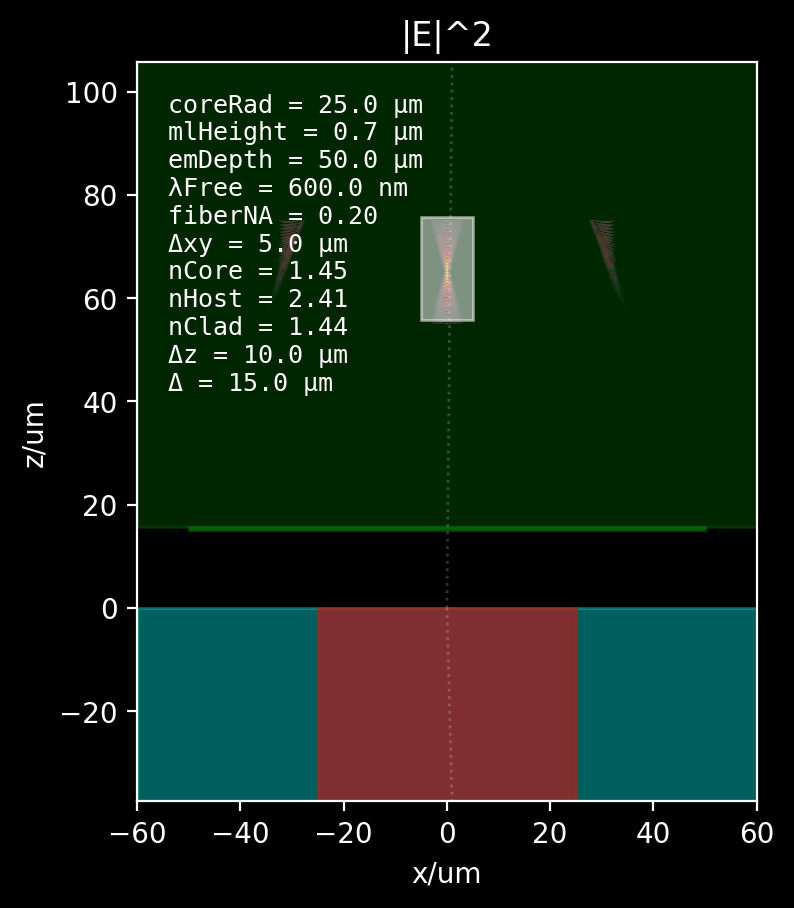

In [78]:
mlHeight = dev_design['mlHeight']
Δ = dev_design['Δ']
fig, ax = ws.device_layout(dev_design)
vmax = np.max(slice)
ax.imshow(slice.T,
        extent=[-b,b,zrange[0]+Δ,zrange[-1]+Δ],
        cmap=cmr.ember,
        norm=LogNorm(vmin=vmax*1e-3, vmax=vmax),
        )
ax.set_xlabel('x/um')
ax.set_ylabel('z/um')
ax.set_title('|E|^2')
fig.savefig('./slices/device_layout.png', dpi=300, bbox_inches='tight')
fig

In [ ]:
def slicer_function(eigen_index):
    dev_design = {'coreRadius':25., 
              'mlRadius':50., 
              'Δ':15., 
              'mlPitch':0.3,
              'NA': 0.22,
              'emDepth':50., 
              'emΔxy':5., 
              'emΔz':10., 
              'mlHeight':0.7, 
              'nCore':1.45, 
              'nHost':2.41, 
              'nCore':1.45, 
              'λFree':0.600}
    # FG050LGA
    fiber_spec = {'NA': 0.22,
                'nCore': 1.45,
                'coreRadius':25.,
                'grid_divider': 2,
                'nFree': 1.,
                'λFree': 0.600}
    fiber_sol = ws.multisolver(fiber_spec, solve_modes = 'transverse', drawPlots=False, verbose=True)
    fiber_sol = ws.calculate_numerical_basis(fiber_sol)
    # grab the data for the mode of interest
    (modtype, m, kzidx, γ, β, Ae, Ah, Be, Bh) = fiber_sol['eigenbasis_nums'][eigen_index]
    kz = fiber_sol['TEkz'][0][0]
    fiber_sol['coord_layout'] = ws.coordinate_layout(fiber_sol)
    a, b, Δs, xrange, yrange, ρrange, φrange, Xg, Yg, ρg, φg, nxy, crossMask, numSamples = fiber_sol['coord_layout']

    totalModes = fiber_sol['totalModes']
    λfree = fiber_sol['λFree']
    eigenbasis = fiber_sol['eigenbasis']
    nCore = fiber_sol['nCore']
    nCladding = fiber_sol['nCladding']

    nFree = 1.0
    Einc = eigenbasis[eigen_index, 0, :, :, :]
    Hinc = np.conjugate(eigenbasis[eigen_index, 1, :, :, :])
    kref, Eref, Href = ws.poyntingrefractor(Einc, Hinc, nFree, nxy, verbose=True)

    print("Converting cylindrical anchored to cartesian into cartesian anchored to cartesian...")
    Erefcc = ws.from_cyl_cart_to_cart_cart(Eref)
    Hrefcc = ws.from_cyl_cart_to_cart_cart(Href)
    ζCoords = np.linspace(-b,b,numSamples)
    ηCoords = np.linspace(-b,b,numSamples)

    print("Propagating the field from across the gap...")
    nref = 1.
    zProp = dev_design['Δ']
    (xCoords, yCoords, E3) = ws.vector_field_FFT_RS_prop_array(zProp, Erefcc, ζCoords, ηCoords, λfree, nref)
    (xCoords, yCoords, H3) = ws.vector_field_FFT_RS_prop_array(zProp, Hrefcc, ζCoords, ηCoords, λfree, nref)

    print("Calculating the ideal Fresnel phase profile...")
    λFree = dev_design['λFree']
    nHost = dev_design['nHost']
    λHost = λFree / nHost
    Rmax = 20 # arbitrary
    emDepth = dev_design['emDepth']
    def fresnel_profile(f):
        phase_fun = lambda x,y: (np.sqrt(x**2+y**2 + f**2)-f)
        return phase_fun
    fp = fresnel_profile(emDepth)
    phase_map = -2*np.pi/λHost * fp(Xg,Yg)
    complex_phase_map = np.exp(1j * phase_map)
    complex_phase_map[Xg**2 + Yg**2 > Rmax**2] = 0

    print("Letting field through meta-optic...")
    E4 = E3 * complex_phase_map
    H4 = H3 * complex_phase_map

    print("Determining range of zProp values to use...")
    dl = xrange[1]-xrange[0]
    emΔz = dev_design['emΔz']
    emDepth = dev_design['emDepth']
    zrange = np.linspace(emDepth-emΔz, emDepth+emΔz, int(2*emΔz/dl))

    print("Filling an empty array for the final fields ...")
    E5 = np.zeros((*E4.shape, len(zrange)))
    H5 = np.zeros((*H4.shape, len(zrange)))

    print("Propagating the field inside of the crystal host...")
    nref = dev_design['nHost']
    λFree = dev_design['λFree']
    for field_index in [0,1]:
        if field_index == 0:
            sourceField = E4
        else:
            sourceField = H4
        for z_index, zProp in enumerate(tqdm(zrange)):
            (xCoords, yCoords, fields) = ws.vector_field_FFT_RS_prop_array(zProp, sourceField, ζCoords, ηCoords, λFree, nref)
            if field_index == 0:
                E5[:, :, :, z_index] = fields
            else:
                H5[:, :, :, z_index] = fields
    print("Grabbing the field along the sagittal plane...")
    midIndex = E5.shape[1] // 2
    slice = E5[:, midIndex, :, :]
    slice = np.sum(np.abs(slice)**2, axis=0)
    fname = '%d.h5' % eigen_index
    fname = os.path.join(scratch_dir, fname)
    with h5py.File(fname, 'w') as f:
        f.create_dataset('out', data=slice, compression='gzip')